In [150]:
### This notebook consists of code used to conduct SINDy analysis of the spline-interpolated latent variables produced
### from the notebook "pySINDy_ETratio_variable_with_coefficient_constraints_worksheet_for_splines".  This analysis is 
### associated with the manuscript, "Data driven model discovery and interpretation for CAR T-cell 
### killing using sparse identification and latent variables".


# load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cvxpy as cp
import pysindy as ps
import sympy as sp
import os
import csv
import math #math fun
import matplotlib.pyplot as plt #plotting
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.filterwarnings("ignore", category=ODEintWarning)
from sklearn.neighbors import NearestNeighbors 
from sklearn.metrics import mean_squared_error
from lmfit import Minimizer, minimize, Parameters, Parameter, report_fit, fit_report
from scipy.integrate import odeint, solve_ivp
from scipy import linalg, interpolate
from pylab import *


## If rpy2 and python are correctly integrated on local machine, then
## import rpy2 to perform splining procedure.  Otherwise, read in
## spreadsheets for splined data
#os.environ["R_HOME"] = r"C:\Program Files\R\R-4.2.0" # use for running on Windows machine, change path as needed
# import rpy2
# import rpy2.robjects as robjects

/var/folders/1g/xj0_6r3j36s5y9k5p4y92b5r0000gn/T/ipykernel_94695/4233223069.py:20: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [151]:
## Read in time series data for cancer cell trajcetories.  Data adapted from [1]

# pbt128_data_path = 'time_series_pbt128.csv'
# pbt128_data = pd.read_csv(pbt128_data_path)`

xcelligence_data_path = 'splined_trajectories_ETratio_low.csv'
xcelligence_data = pd.read_csv(xcelligence_data_path,usecols=[1,2,3,4,5,6])

In [152]:
xcelligence_data

,time_trial1_(hrs),tumor_cells_trial1_(ci),cart_cells_trial1_(ci),time_trial2_(hrs),tumor_cells_trial2_(ci),cart_cells_trial2_(ci)
0,33.337500,1.149224,0.090298,33.337500,0.684336,0.107258
1,33.587500,1.197259,0.090407,33.587500,0.776898,0.106721
2,33.837778,1.245229,0.090557,33.837778,0.867903,0.106235
3,34.088056,1.293072,0.090747,34.088056,0.957259,0.105798
4,34.338056,1.340722,0.090976,34.338056,1.044884,0.105412
...,...,...,...,...,...,...
520,163.481944,2.755838,0.200076,163.481944,3.347450,0.198162
521,163.732222,2.761241,0.200683,163.732222,3.355811,0.198800
522,163.982222,2.766672,0.201311,163.982222,3.364243,0.199461
523,164.236667,2.772234,0.201972,164.236667,3.372908,0.200157


In [153]:
trial1_time = xcelligence_data['time_trial1_(hrs)'].to_numpy()
trial2_time = xcelligence_data['time_trial2_(hrs)'].to_numpy()

trial1_data = xcelligence_data[['tumor_cells_trial1_(ci)', 'cart_cells_trial1_(ci)']].to_numpy()
trial2_data = xcelligence_data[['tumor_cells_trial2_(ci)', 'cart_cells_trial2_(ci)']].to_numpy()

time = [trial1_time, trial2_time]
print(time[0])
trial1_data[:,:]
data = [trial1_data, trial2_data]
print(data[0])


# time = []
# time.append(trial1_time)
# time.append(trial2_time)
# print(time)

[ 33.3375    33.5875    33.837778  34.088056  34.338056  34.588333
  34.838056  35.088333  35.338611  35.588889  35.838889  36.089167
  36.339444  36.589167  36.839444  37.089444  37.339722  37.589722
  37.84      38.090278  38.340278  38.590556  38.840556  39.090833
  39.340833  39.591111  39.841111  40.091389  40.341667  40.591389
  40.841667  41.091389  41.341667  41.591667  41.841944  42.092222
  42.341944  42.591389  42.841389  43.091667  43.341667  43.591944
  43.841944  44.092222  44.3425    44.5925    44.842778  45.092778
  45.342778  45.592778  45.842778  46.093056  46.343056  46.593333
  46.843333  47.093611  47.343611  47.593611  47.843611  48.093611
  48.343889  48.593889  48.844167  49.094167  49.344167  49.594167
  49.842778  50.092222  50.3425    50.592778  50.842778  51.093056
  51.343333  51.593611  51.843889  52.093611  52.343889  52.593889
  52.844167  53.094444  53.344722  53.595     53.845     54.095
  54.345     54.595     54.845     55.095278  55.345556  55.59583

In [154]:
################################################################################
################ Implementing pySINDy with constraints #########################
################################################################################

### Here we implement the SINDy with constraints, and return to the pareto front 
### optimization approach.

differentiation_method = ps.SmoothedFiniteDifference(order = 3)
feature_library = ps.PolynomialLibrary(degree = 3, include_bias = False)
# the include_bias parameter toggles presence of constant terms in library.

feature_library.fit(data[0])

n_features = feature_library.n_output_features_
n_targets = data[0].shape[1]
print(f"Features ({n_features}):", feature_library.get_feature_names())
print(n_features)
print(n_targets)

Features (9): ['x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']
9
2


In [155]:
# Set inequality constraints
eps = 1e-7

# constraints irrespective of growth rate in x and positive xy^2
constraint_rhs = np.array([eps, eps, eps, eps, eps, eps, eps, eps, eps,
                          eps, eps, eps, eps, eps, eps, eps, eps, eps, eps])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((19, n_targets * n_features))


## Zero out coefficients on y in xdot equation.
# 1 * (x1 coefficient) <= eps
constraint_lhs[0, 1] = 1

# 1 * (x1^2 coefficient) <= eps
constraint_lhs[1, 4] = 1

# 1 * (x1^3 coefficient) <= eps
constraint_lhs[2, 8] = 1

# -eps <= 1*(x1 coefficient)
constraint_lhs[3, 1] = -1

# -eps <= 1*(x1^2 coefficient)
constraint_lhs[4, 4] = -1

# -eps <= 1*(x1^3 coefficient)
constraint_lhs[5, 8] = -1

## Zero out coefficients on x in ydot equation.
# 1 * (x0 coefficient) <= eps
constraint_lhs[6, 9] = 1

# 1 * (x0^2 coefficient) <= eps
constraint_lhs[7, 11] = 1

# 1 * (x0^3 coefficient) <= eps
constraint_lhs[8, 14] = 1

# -eps <= 1*(x0 coefficient)
constraint_lhs[9, 9] = -1

# -eps <= 1*(x0^2 coefficient)
constraint_lhs[10, 11] = -1

# -eps <= 1*(x0^3 coefficient)
constraint_lhs[11, 14] = -1

# Force negativity of coeficient on xy^2 in xdot equation.
# 0 <= 1 * (x0x1^2 coefficient)
constraint_lhs[12, 7] = 1

# Force negativity of coeficient on xy^2 in ydot equation.
# 0 <= 1 * (x0 coefficient)
constraint_lhs[13, 16] = 1

## Zero out coefficients on x^2y in xdot equation.
# 1 * (x0 coefficient) <= eps
constraint_lhs[14, 6] = 1

# -eps <= 1*(x0 coefficient)
constraint_lhs[15, 6] = -1

## Force negativity of coeficient on x^3 in xdot equation.
# 0 >= 1 * (x0^3 coefficient)
constraint_lhs[16, 5] = 1

## Force negativity of coeficient on y^3 in ydot equation.
# 0 >= 1 * (x1^3 coefficient)
constraint_lhs[17, 17] = 1

## Force negativity of coeficient on xy in xdot equation.
# 0 >= 1 * (x0x1 coefficient)
constraint_lhs[18, 3] = 1

# Define the optimizer to be used and associated optimization parameters
# Run a single instance of SINDy to see it works.
optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,
    thresholder="l1",
    tol=1e-5,
    threshold=5e-1,
    max_iter=10000
)
model = ps.SINDy(optimizer=optimizer,
                 feature_library=feature_library,
                feature_names = ["x", "y"],
                differentiation_method = differentiation_method)

model.fit(data, t = time, multiple_trajectories = True)

model.print()
model.coefficients()

(x)' = 0.143 x + -0.012 x^2 + -0.517 x y
(y)' = 0.000


array([[ 1.43141536e-01,  2.51864687e-14, -1.16470413e-02,
        -5.16982813e-01, -5.46521194e-16,  1.00000014e-07,
         1.00000003e-07,  3.33333349e-08, -3.33333330e-08],
       [ 1.30926012e-06, -4.77363999e-07,  6.03644958e-06,
        -7.36460426e-07, -1.65254155e-07,  3.37045683e-06,
         4.62876364e-04, -2.08091165e-07, -5.99405983e-08]])

In [156]:
### Perform pareto front analysis and loop through many values of threshold 
### to identify parsimonious model.

num_terms = []

## This spread was used for all figures but histograms of coefficients.  There are 36 values in this list.
threshold_vals = [1e-8, 2.5e-8, 5e-8, 7.5e-8, 1e-7, 2.5e-7, 5e-7, 7.5e-7, 
                 1e-6, 2.5e-6, 5e-6, 7.5e-6, 1e-5, 2.5e-5, 5e-5, 7.5e-5, 
                 1e-4, 2.5e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 
                 1e-2, 2.5e-2, 5e-2, 7.5e-2, 1e-1, 2.5e-1, 5e-1, 7.5e-1, 
                 1e0, 2.5e0, 5e0, 7.5e0]

## This spread is used for histograms of coefficients.  There are 1000 values in this list.
#threshold_vals = np.linspace(0.5e-2, 1e1, 1000)
models = []
coefs = []

for i in range(0, 36):
    
    optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    inequality_constraints=True,
    thresholder="l1",
    tol=1e-5,
    threshold=threshold_vals[i],
    max_iter=10000)
#    print(threshold_vals[i])
    
    models.append(ps.SINDy(optimizer=optimizer,
                 feature_library=feature_library,
                feature_names = ["x", "y"],
                differentiation_method = differentiation_method))

    
    models[i].fit(data, t = time, multiple_trajectories = True)
    num_terms.append(sum(abs(models[i].coefficients())>=1e-3))
    coefs.append(models[i].coefficients())
    
print(num_terms)

[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 3, 3, 3, 3, 3, 3, 3]


In [157]:
## Testing with calculating mean squared error 
## Here, score is calculated based on estimates/predictions of the time derivatives

score = []
deriv_score = []
for i in range(0,len(threshold_vals)):
    deriv_score.append(models[i].score(data, t=time, 
                                  metric = mean_squared_error, multiple_trajectories = True))
    pred_rmse = 0

    for j in range(0,len(data)):
        num_data_points = data[j].shape[0]*data[j].shape[1]
        prediction = models[i].simulate(data[j][0,:], time[j], integrator = 'odeint')
        pred_rmse = pred_rmse + np.sqrt(np.sum(np.square(prediction - data[j]))/num_data_points)
    score.append(pred_rmse/len(data))


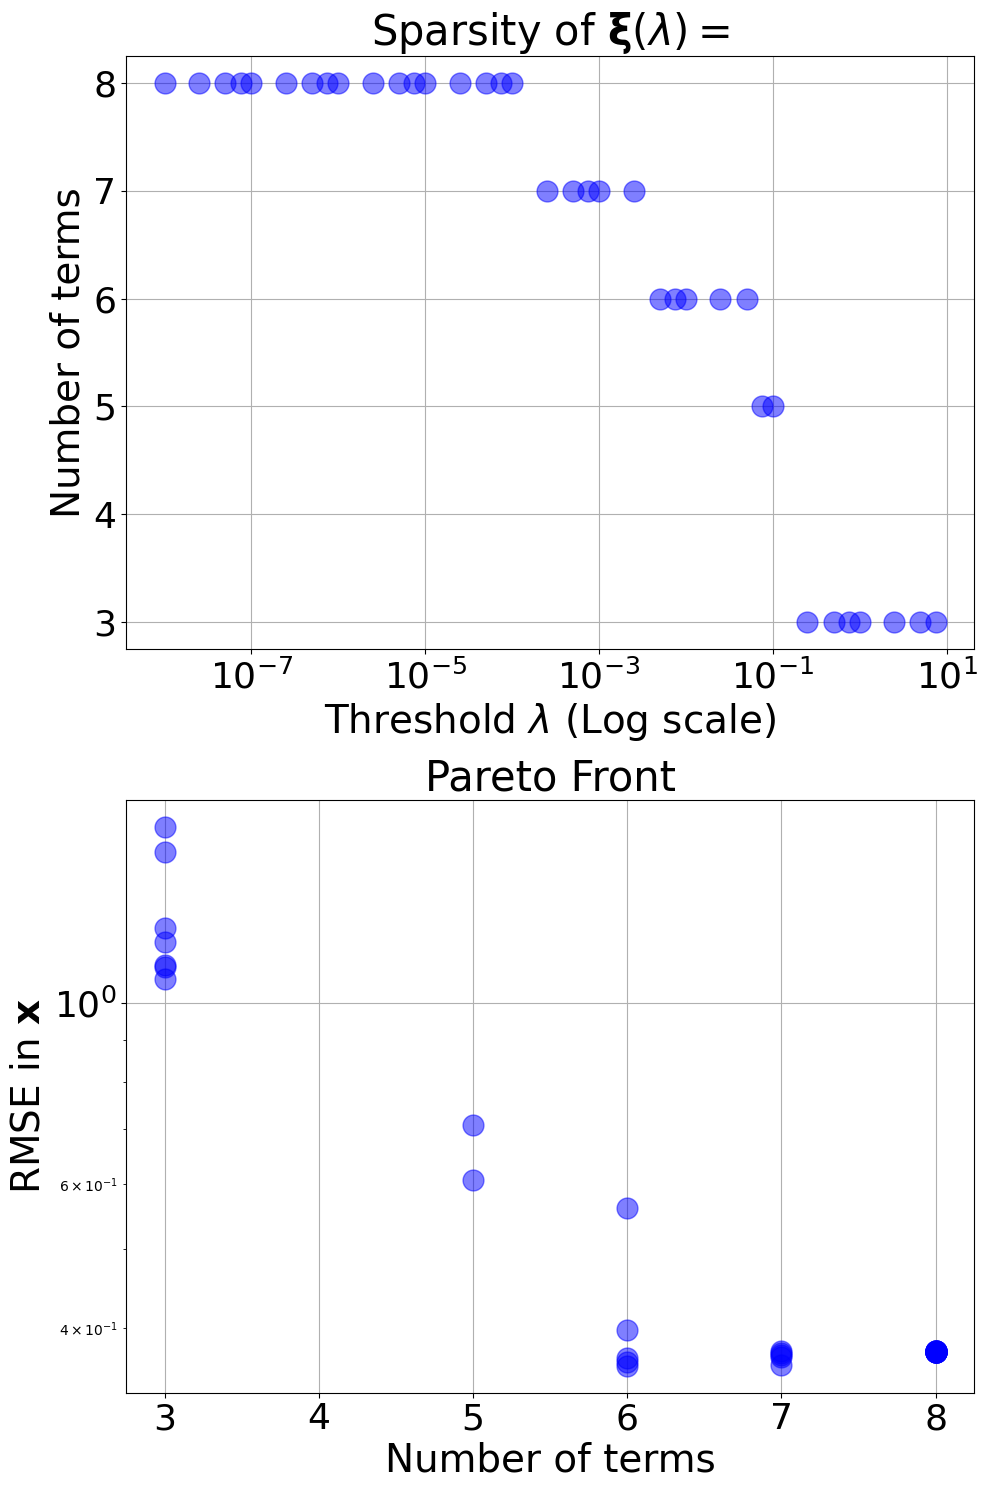

In [158]:
###  Graphing pareto fronts for active library terms

plt.figure(figsize = (10,15))


ax1 = plt.subplot(2,1,1)
plt.semilogx(threshold_vals, num_terms, "bo", markersize = 15, alpha = 0.5)
plt.title(r'Sparsity of $\mathbf{\xi}(\lambda) = {\mathbf{N}\alpha(\lambda)$', fontsize = 30)
plt.xlabel(r'Threshold $\lambda$ (Log scale)', fontsize = 28)
plt.ylabel('Number of terms', fontsize = 28)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.grid(True)
#plt.semilogx(threshold_vals, score, "b")

ax2 = plt.subplot(2,1,2)
plt.semilogy(num_terms, score, "bo", markersize = 15, alpha = 0.5)
#plt.ylim((1e0, 1e9))
plt.title('Pareto Front', fontsize = 30)
plt.ylabel(r'RMSE in $\mathbf{x}$', fontsize = 28)
plt.xlabel('Number of terms', fontsize = 28)
plt.xticks(fontsize = 26)
plt.yticks(fontsize = 26)
plt.grid(True)

plt.tight_layout()
plt.show()

In [159]:
models[22].print()
models[22].coefficients()

(x)' = 0.150 x + -0.012 x^2 + -0.545 x y
(y)' = -0.002 x y + 0.005 x^2 y + -0.063 x y^2


array([[ 1.50199740e-01, -9.30133789e-14, -1.20936720e-02,
        -5.45233568e-01,  9.24814689e-15,  1.00000001e-07,
         1.00000008e-07,  3.33333678e-08,  2.29653684e-15],
       [ 2.86245143e-06,  1.08801964e-07,  6.79971397e-06,
        -1.82449232e-03,  1.92785849e-07,  4.14045705e-06,
         5.44263909e-03, -6.32354777e-02,  1.02688766e-07]])

In [160]:
# high E:T is 0 when constraining x^2y and x^3.  RMSE should read 0.02423
# medium E:T is 13 when constraining x^2y and x^3.  RMSE should read 0.1946
# low E:T is 22 when constraining x^2y and x^3.  RMSE should read 0.3594


print(num_terms.index(8))
print(num_terms[13])
print(score[13])

0
8
0.37393332481798613


In [161]:
forward_time = [np.array(np.linspace(time[0][0], 1.5*time[0][-1], 3*len(time[0]))),
               np.array(np.linspace(time[1][0], 1.5*time[1][-1], 3*len(time[1]))),
               np.array(np.linspace(time[1][0], 1.5*time[1][-1], 3*len(time[1])))]
print(forward_time)

[array([ 33.3375    ,  33.47307709,  33.60865417, ..., 246.46467983,
       246.60025691, 246.735834  ]), array([ 33.3375    ,  33.47307709,  33.60865417, ..., 246.46467983,
       246.60025691, 246.735834  ]), array([ 33.3375    ,  33.47307709,  33.60865417, ..., 246.46467983,
       246.60025691, 246.735834  ])]


In [162]:
model_num = 22
x_test_sim_arr = []
x_forward_sim_arr = []
pred_rmse = []


for i in range(0,len(data)):
    x_test_sim_arr.append(models[model_num].simulate(data[i][0,:], time[i],
                                    integrator = 'odeint'))
    x_forward_sim_arr.append(models[model_num].simulate(data[i][0,:], forward_time[i],
                                    integrator = 'odeint'))
    num_data_points = data[i].shape[0]*data[i].shape[1]
    pred_rmse = np.sqrt(np.sum(np.square(x_test_sim_arr[i] - data[i]))/num_data_points)

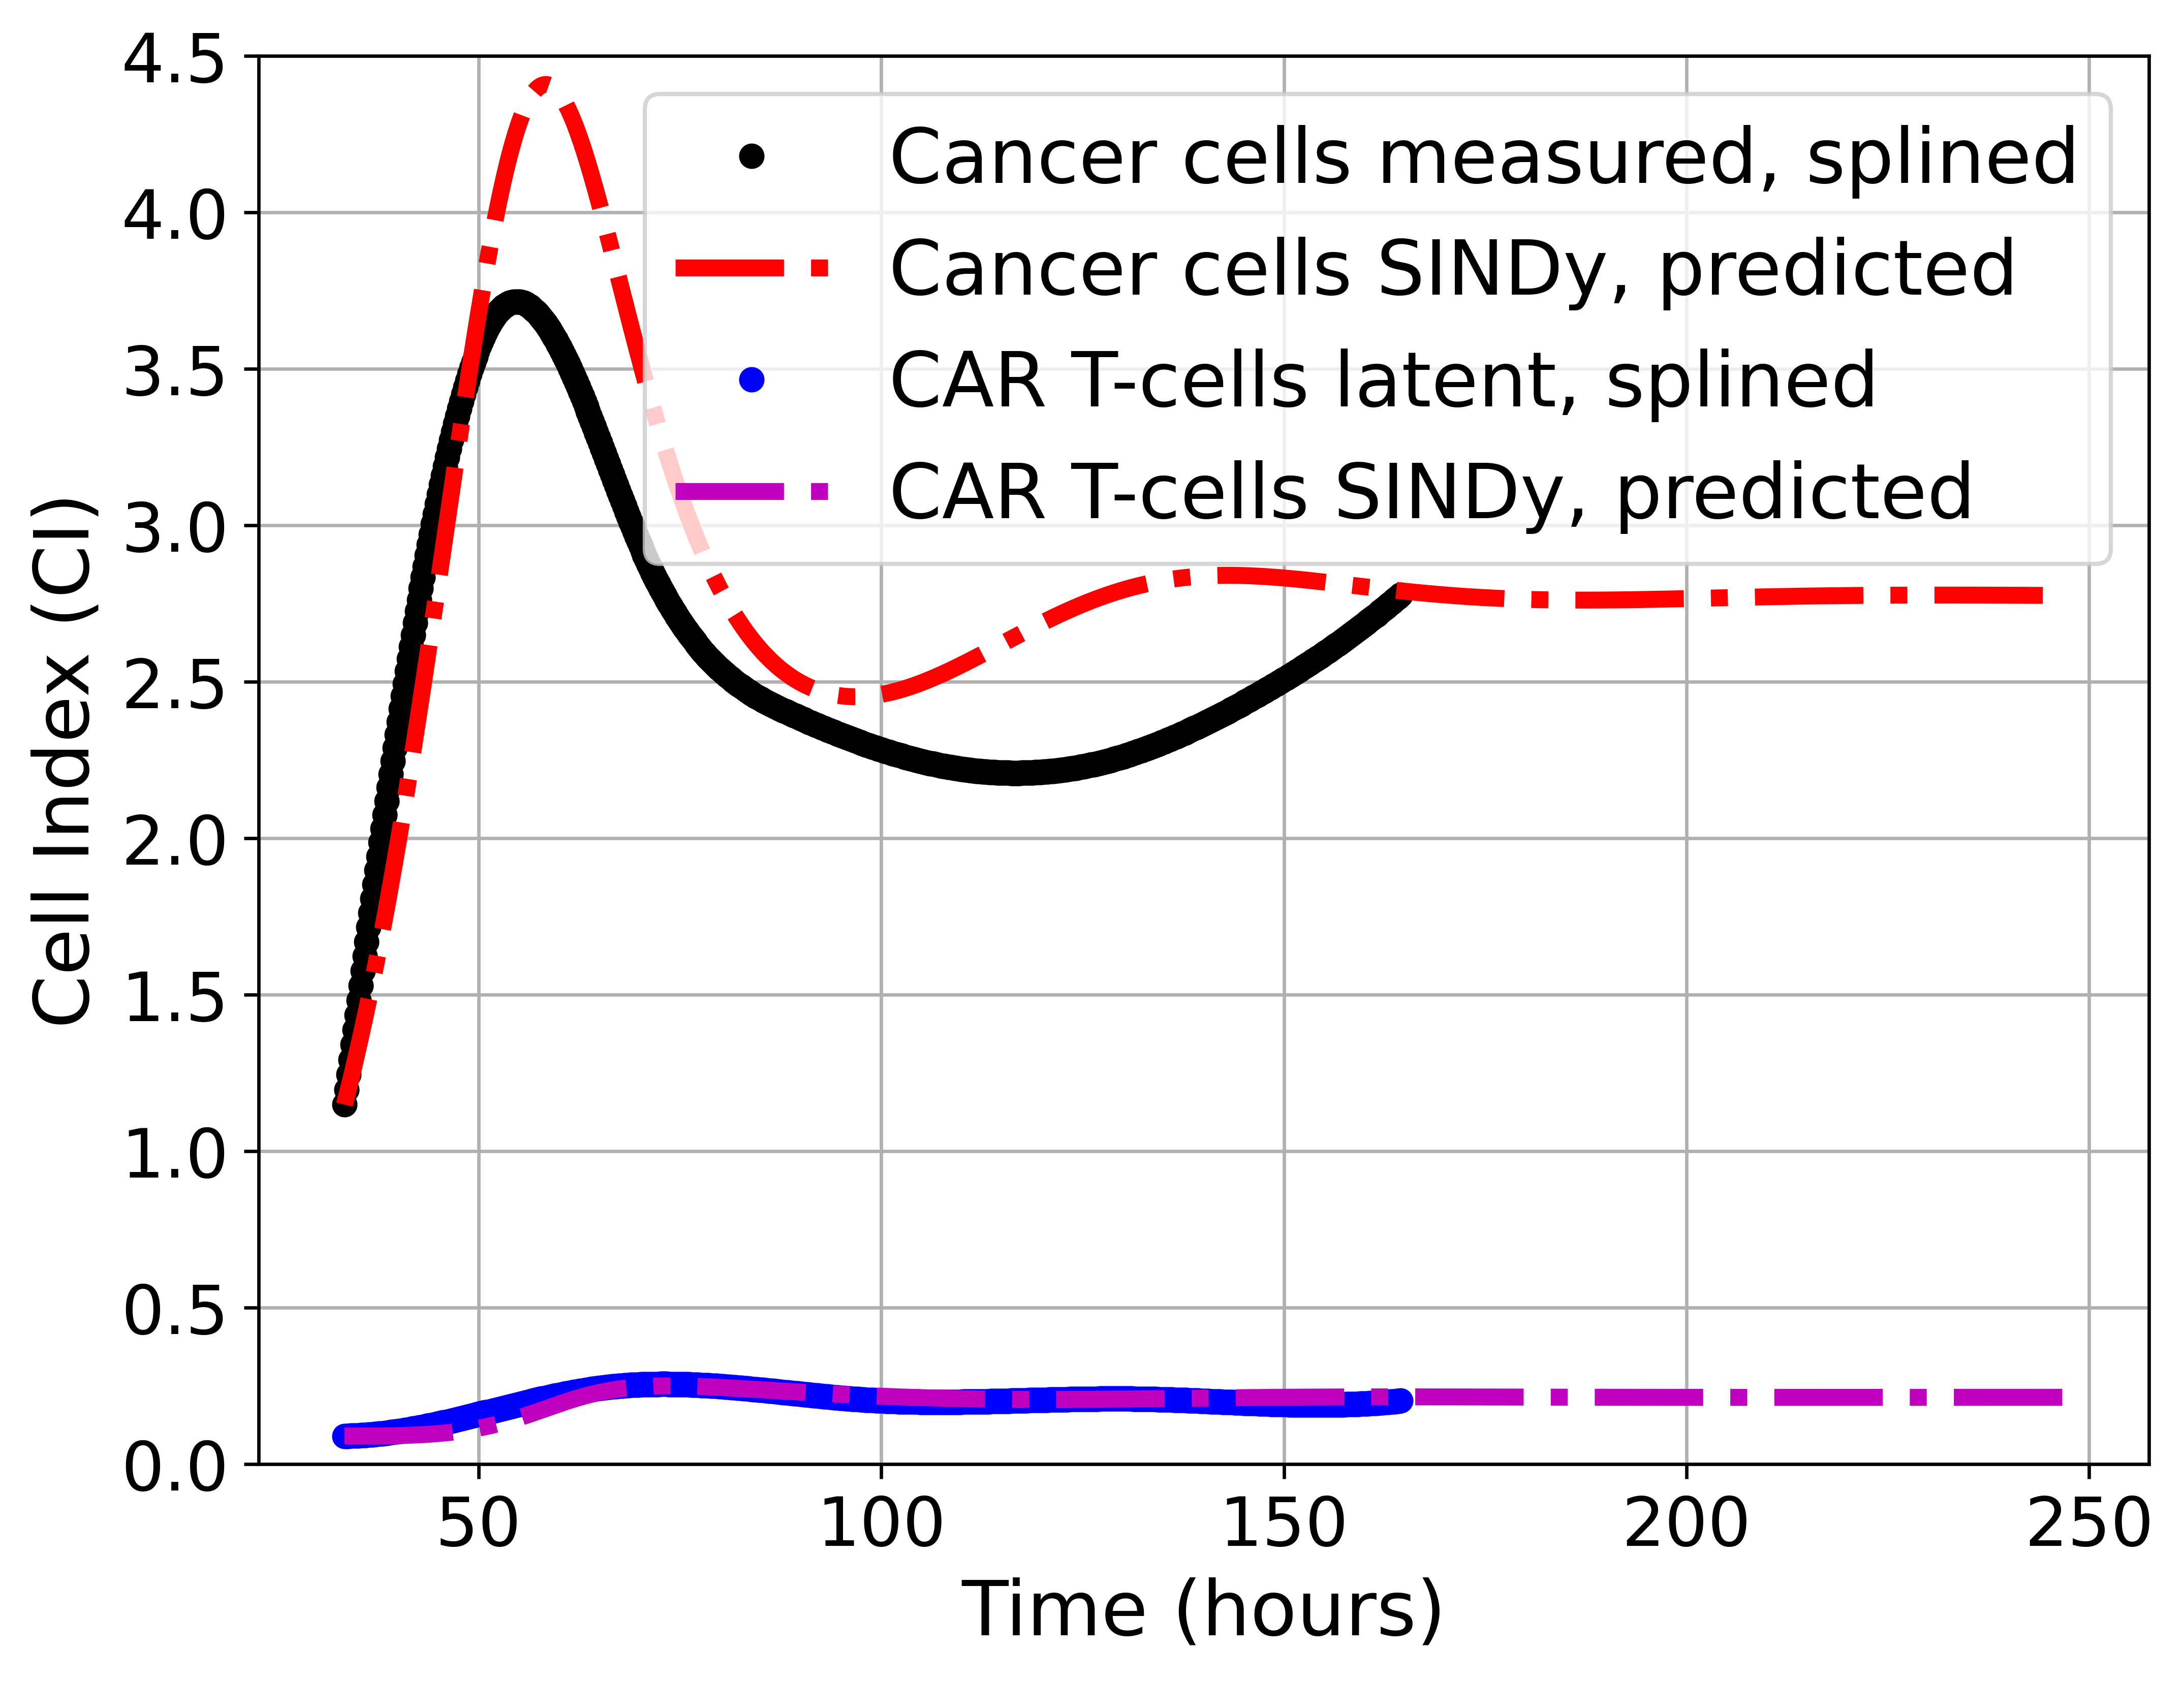

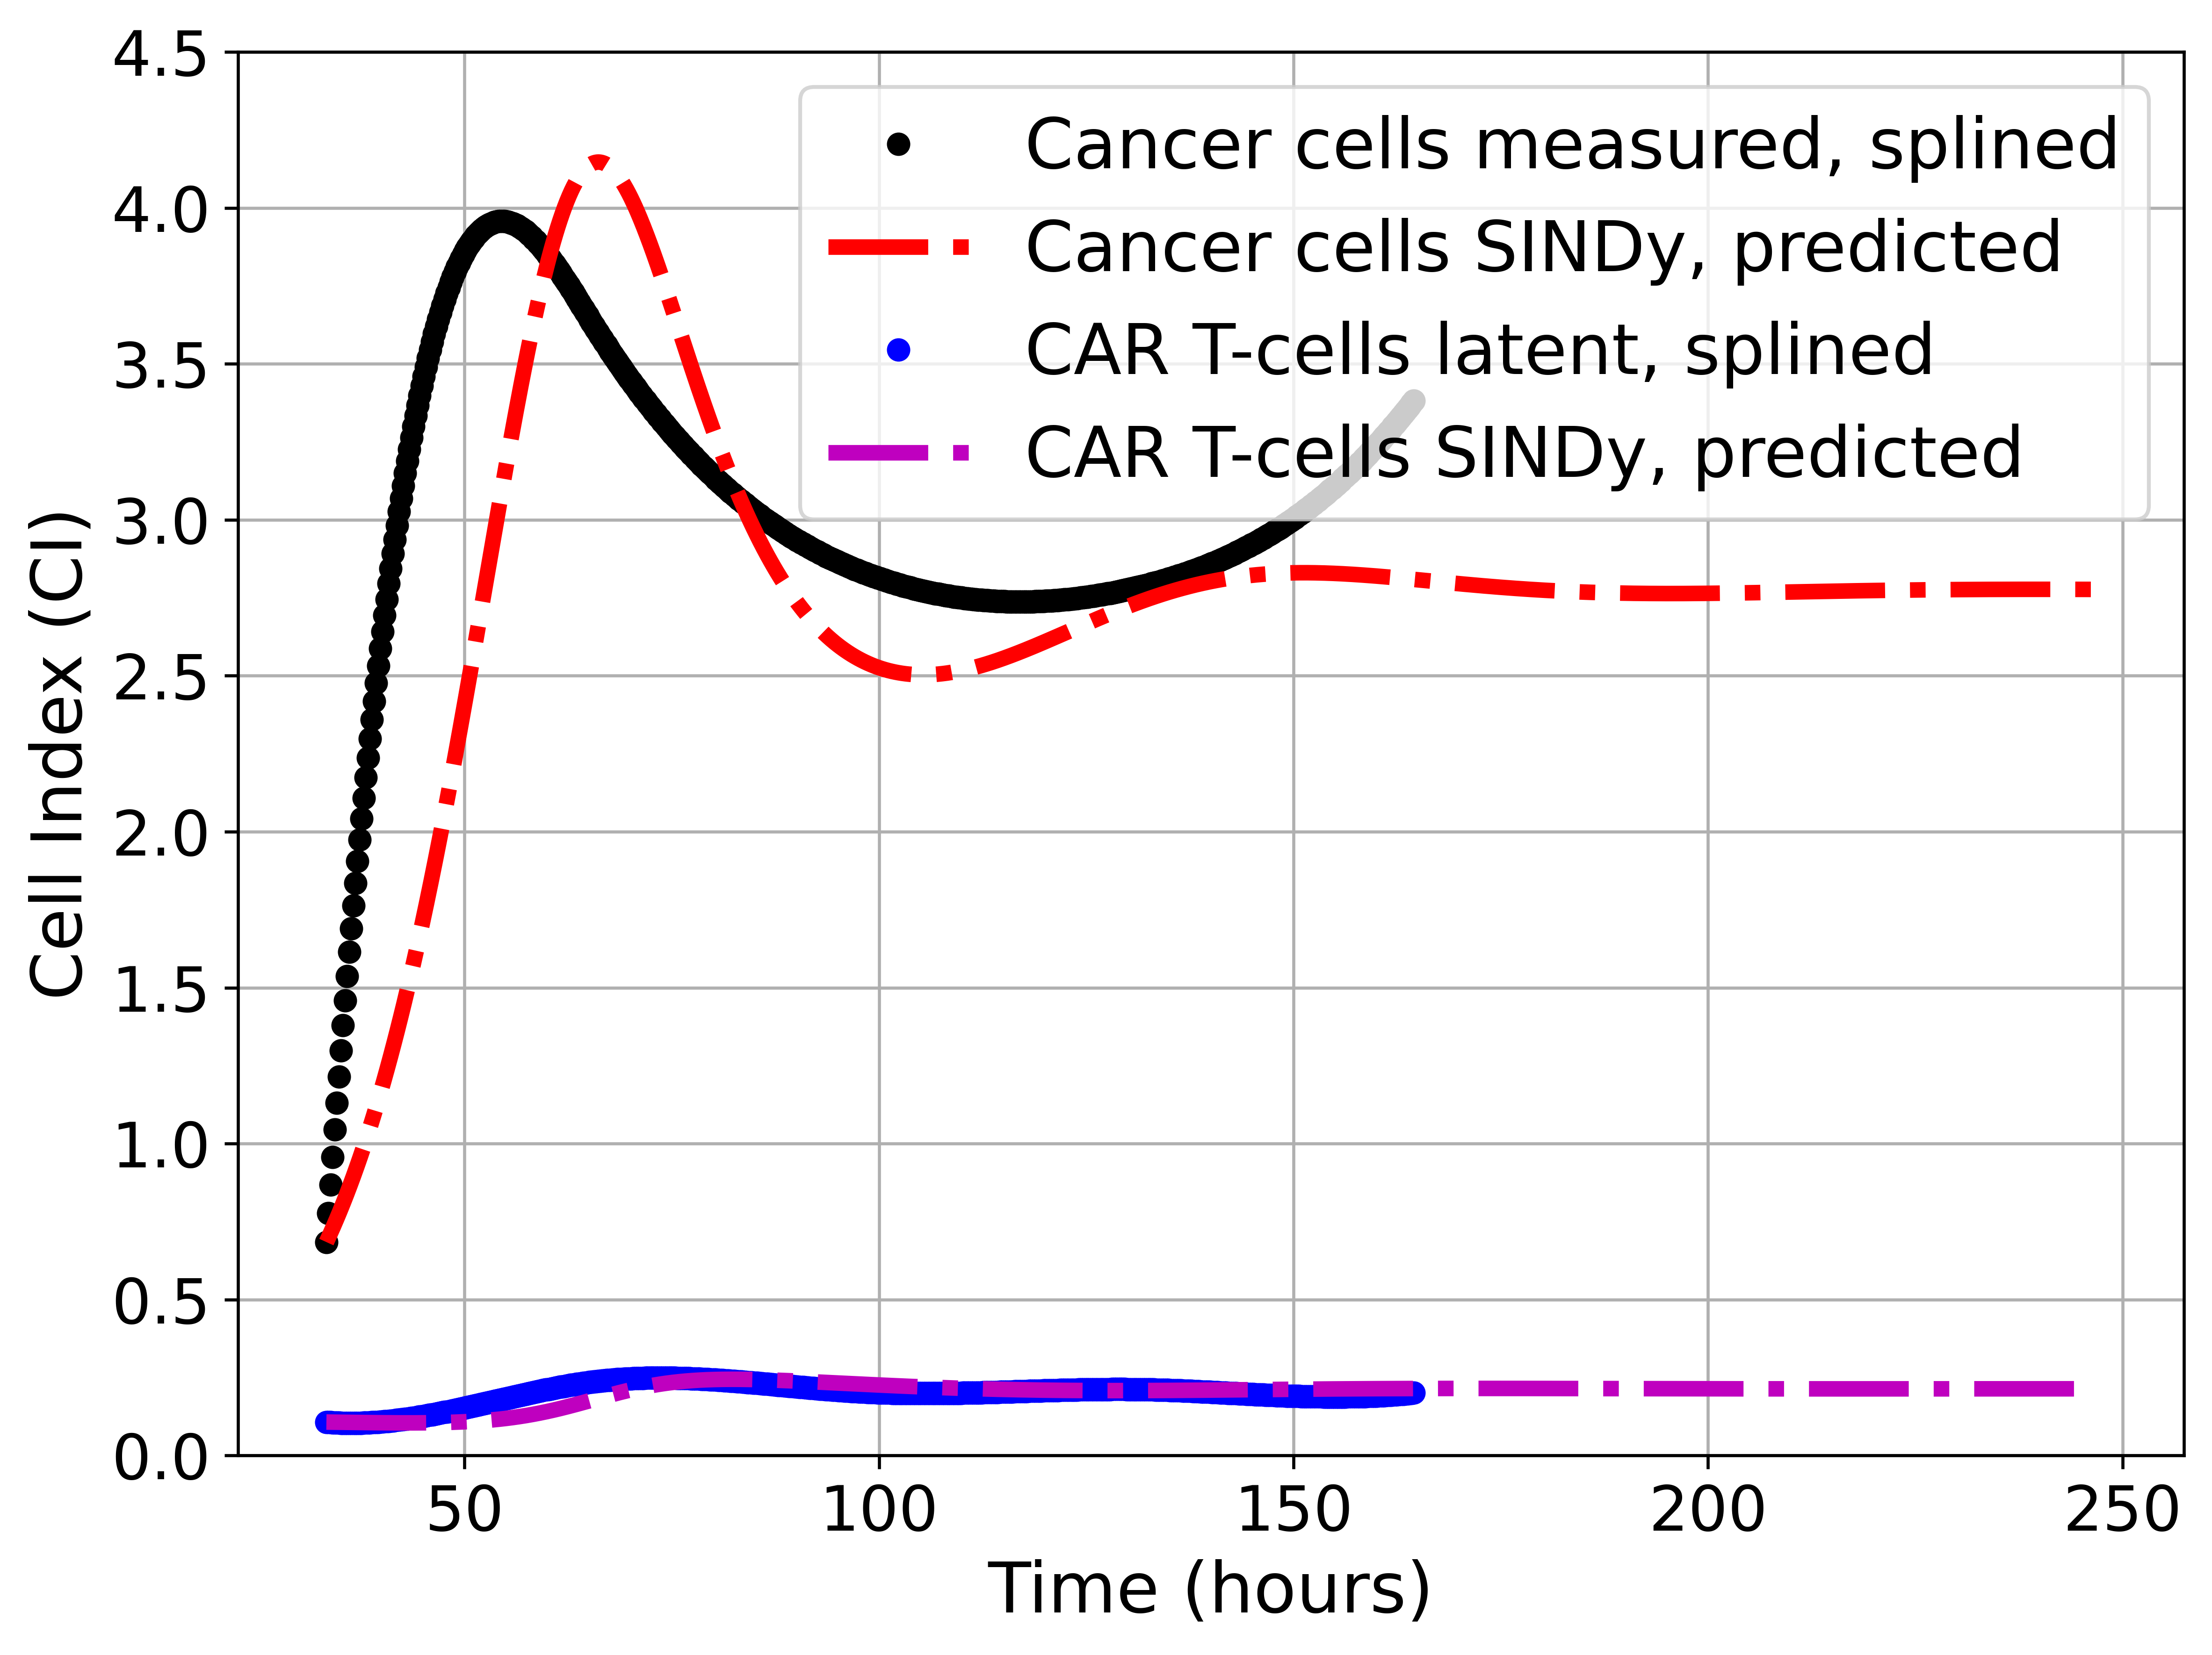

In [163]:
### Plot a stack of the two trials using the given model.

plt.figure(figsize = (8,6), dpi = 600)
#ax1 = plt.subplot(2,1,1)
plt.plot(time[0], data[0][:,0],
        'k.', label = 'Cancer cells measured, splined', markersize = 10)
plt.plot(forward_time[0], x_forward_sim_arr[0][:,0],
         'r-.', label = 'Cancer cells SINDy, predicted', linewidth = 4)
plt.plot(time[0], data[0][:,1],
        'b.', label = 'CAR T-cells latent, splined', markersize = 10)
plt.plot(forward_time[0], x_forward_sim_arr[0][:,1],
        'm-.', label = 'CAR T-cells SINDy, predicted', linewidth = 4)
plt.xlabel('Time (hours)', fontsize = 18)
plt.ylabel('Cell Index (CI)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0,4.5)
#plt.title()
plt.grid(True)
plt.legend(fontsize = 18, loc = 'upper right')

plt.figure(figsize = (8,6), dpi = 600)
#ax2 = plt.subplot(2,1,2)
plt.plot(time[1], data[1][:,0],
        'k.', label = 'Cancer cells measured, splined', markersize = 10)
plt.plot(forward_time[1], x_forward_sim_arr[1][:,0],
         'r-.', label = 'Cancer cells SINDy, predicted', linewidth = 4)
plt.plot(time[1], data[1][:,1],
        'b.', label = 'CAR T-cells latent, splined', markersize = 10)
plt.plot(forward_time[1], x_forward_sim_arr[1][:,1],
        'm-.', label = 'CAR T-cells SINDy, predicted', linewidth = 4)
plt.ylabel('Cell Index (CI)', fontsize = 18)
plt.xlabel('Time (hours)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(0,4.5)
#plt.title()
plt.grid(True)
plt.legend(fontsize = 18, loc = 'upper right')

plt.tight_layout()
plt.show()

In [48]:
coeffs_array = np.zeros([1000, 2,14])

In [49]:
for i in range(0,len(models)):
    coeffs_array[i,:,:] = models[i].coefficients()
feature_names = ['x', 'y']
min_overall = -0.6
max_overall = 0.2
xticknames = models[0].get_feature_names()

In [50]:
coeffs_array

array([[[ 5.81418494e-02, -2.35462336e-07,  9.73842865e-02, ...,
         -3.61957267e-08, -7.88672040e-01,  1.64278418e-02],
        [-3.99334338e-05,  6.30758444e-01,  1.84007092e-05, ...,
          1.36993046e-01, -1.18762798e+00,  5.77310320e-01]],

       [[ 5.81418494e-02, -2.35488633e-07,  9.73842865e-02, ...,
         -3.61993167e-08, -7.88672040e-01,  1.64278420e-02],
        [-4.00215103e-05,  6.30582716e-01,  1.82475455e-05, ...,
          1.36918157e-01, -1.18701232e+00,  5.77407367e-01]],

       [[ 5.81418493e-02, -2.35525017e-07,  9.73842866e-02, ...,
         -3.62067262e-08, -7.88672040e-01,  1.64278423e-02],
        [-4.03923300e-05,  6.30290353e-01,  1.78201772e-05, ...,
          1.36796079e-01, -1.18598974e+00,  5.77569859e-01]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000

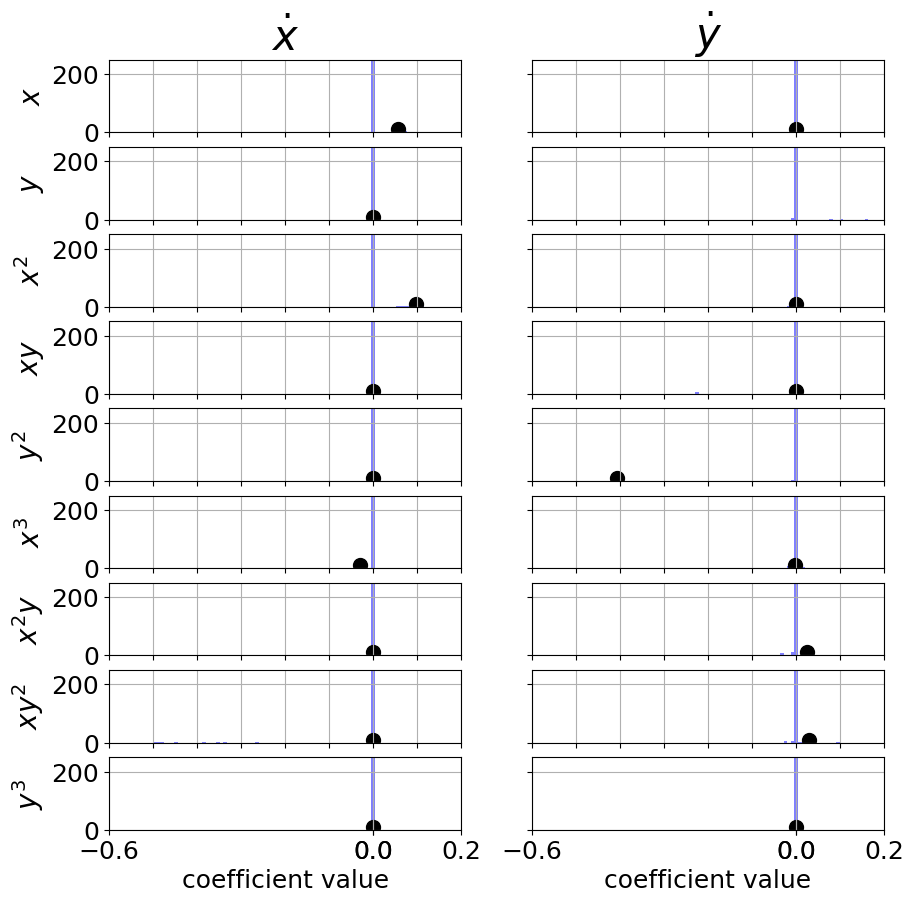

In [51]:
# Loop through each element in the coefficients

plt.figure(figsize = (10,10))
for j in range(9):
    for i in range(2):
        plt.subplot(9, 2, i + 1 + j * 2)
        if j == 0:
            plt.title('$\dot{'+feature_names[i]+'}$', fontsize=30)
        bins = np.linspace(min_overall, max_overall, 101)
        plt.hist(coeffs_array[:, i, j], color='b', bins=bins,
                 label='ensemble', align='left', alpha = 0.5)
#       plt.hist(library_ensemble_coefs[:, i, j], bins=bins,
#                 color='r', alpha=0.5, label='library ensemble', align='left')
        plt.scatter(models[21].coefficients()[i, j], 10, color='k',
                    label='true value', s=100, marker='o')
        plt.grid(True)
        ax = plt.gca()
        if i == 0:
            plt.ylabel('$'+xticknames[j]+'$', fontsize=20)
#            plt.xlim(-1,1)
        else:
            ax.set_yticklabels([])
        if j != 8:
            ax.set_xticklabels([])
        else:
            plt.xlabel('coefficient value', fontsize=18)
            ax.set_xticks([min_overall, 0, max_overall // 2, max_overall])
        plt.ylim(0, 250)
        plt.xlim(min_overall, max_overall)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        if i == 1 and j == 9:
            plt.legend(fontsize=16)

# References

#### [1] Brummer, A.B.; Yang, X.; Ma, E.; Gutova, M.; Brown, C.E.; Rockne, R.C. Dose-dependent thresholds of 
####     dexamethasone destabilize CAR T-cell treatment efficacy. PLOS Computational Biology 2022, 18, e1009504.
#### [2] Tigurius. (May, 2018). Introduction to Taken's Embedding. Version 6. Last Retrieved October 4, 2022 from 
####     https://www.kaggle.com/code/tigurius/introduction-to-taken-s-embedding
#### [3] de Silva, B.M.; Champion, K.; Quade, M.; Loiseau, J.C.; Kutz, J.N.; Brunton, S.L. PySINDy: A Python package 
####     for the sparse identification of nonlinear dynamical systems from data. Journal of Open Source Software 
####     2020, 5, 2104. https://doi.org/10.21105/joss.02104.
#### [4] Kaptanoglu, A.A.; de Silva, B.M.; Fasel, U.; Kaheman, K.; Goldschmidt, A.J.; Callaham, J.; Delahunt, C.B.; 
####     Nicolaou, Z.G.; Champion, K.; Loiseau, J.C.; et al. PySINDy: A comprehensive Python package for robust 
####     sparse system identification. Journal of Open Source Software 2022, 7, 3994. 
####     https://doi.org/10.21105/joss.03994.

